In [1]:
import scvelo as scv
import scanpy as sc
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import utils
import importlib
import pandas as pd
import anndata as ad
import mygene
importlib.reload(utils)
import gc

In [2]:
DATA_DIR = Path("/root/autodl-tmp/dataset") 
DATASET = "murine_embryonic"
K_FOLD = 3
CLUSTER_KEY = 'stage'
SEED = 1234

In [3]:
(DATA_DIR / DATASET / "raw").mkdir(parents=True, exist_ok=True)
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

## Load the full dataset

In [4]:
all_adata = sc.read_h5ad(DATA_DIR / DATASET / "raw" / f"{DATASET}.h5ad")
adata = all_adata[all_adata.obs['sequencing_center']=='Kelly'].copy()

In [5]:
# 将基因名转为symbol
mg = mygene.MyGeneInfo()
ensembl_ids = adata.var_names.tolist()
query_results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='mouse')
id_to_symbol = {item['query']: item.get('symbol', None) for item in query_results if 'symbol' in item}
new_var_names = [id_to_symbol.get(gid, gid) for gid in adata.var_names]
adata.var_names = new_var_names
adata.var_names_make_unique()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
3 input query terms found dup hits:	[('ENSMUSG00000072694', 2), ('ENSMUSG00000115230', 2), ('ENSMUSG00000106441', 2)]
248 input query terms found no hit:	['ENSMUSG00000116164', 'ENSMUSG00000107053', 'ENSMUSG00000086955', 'ENSMUSG00000085542', 'ENSMUSG000


In [6]:
# 导入并合并loom data
GSMIDs = ['GSM4227224','GSM4227225','GSM4227226','GSM4227227']
loom_list = []
for GSMID in GSMIDs:
    ldata = sc.read(DATA_DIR / DATASET / "raw" / f"run_count_{GSMID}.loom")
    ldata.obs_names = [
        name.split(":")[1][:-1] + f"-{GSMID}-Kelly"
        for name in ldata.obs_names
    ]
    ldata.var_names_make_unique()
    loom_list.append(ldata)
    del ldata
loom_merged = ad.concat(loom_list, axis=0, join="outer", label="GSMID", keys=GSMIDs)
loom_merged.write(DATA_DIR / DATASET / "raw" / "loom_merged.h5ad")

In [7]:
shared_obs_names = loom_merged.obs_names.intersection(adata.obs_names)
shared_var_names = loom_merged.var_names.intersection(adata.var_names)
loom_sub = loom_merged[shared_obs_names, shared_var_names].copy()
adata = adata[shared_obs_names, shared_var_names].copy()

In [8]:
adata.layers['spliced'] = loom_sub.layers['spliced']
adata.layers['unspliced'] = loom_sub.layers['unspliced']
adata.obs['stage'] = pd.Categorical(adata.obs['stage'])

In [9]:
# adata.write(DATA_DIR / DATASET / "raw" / f"{DATASET}_for_downsample.h5ad")

## Split the data

In [10]:
sub_adata_lst = utils.split_anndata_stratified(adata, n_splits=K_FOLD, cluster_key=CLUSTER_KEY)

## Preprocessing each sub adata

In [11]:
adata.layers['raw_spliced'] = adata.layers['spliced']
adata.layers['raw_unspliced'] = adata.layers['unspliced']
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
if adata.n_vars < 2000:
    sc.pp.highly_variable_genes(adata, n_top_genes=adata.n_vars, subset=True)
if 'X_pca' in adata.obsm:
    del adata.obsm['X_pca']
    del adata.uns['pca']
if "neighbors" in adata.uns.keys():
    del adata.uns['neighbors']
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
utils.fill_in_neighbors_indices(adata)
sc.tl.umap(adata, random_state=SEED)
adata.obs['u_lib_size_raw'] = adata.layers['raw_unspliced'].toarray().sum(-1) 
adata.obs['s_lib_size_raw'] = adata.layers['raw_spliced'].toarray().sum(-1)
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_full.h5ad")
del adata
gc.collect()

for i in range(len(sub_adata_lst)):
    sub_adata = sub_adata_lst[i].copy()
    sub_adata.layers['raw_spliced'] = sub_adata.layers['spliced']
    sub_adata.layers['raw_unspliced'] = sub_adata.layers['unspliced']
    scv.pp.filter_and_normalize(sub_adata, min_shared_counts=20, n_top_genes=2000)
    if sub_adata.n_vars < 2000:
        sc.pp.highly_variable_genes(sub_adata, n_top_genes=sub_adata.n_vars, subset=True)
    if 'X_pca' in sub_adata.obsm:
        del sub_adata.obsm['X_pca']
        del sub_adata.uns['pca']
    if "neighbors" in sub_adata.uns.keys():
        del sub_adata.uns['neighbors']
    scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
    utils.fill_in_neighbors_indices(sub_adata)
    sc.tl.umap(sub_adata, random_state=SEED)
    sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].toarray().sum(-1) 
    sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].toarray().sum(-1)
    if SAVE_DATA:
        sub_adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_{i}.h5ad")
    del sub_adata
    gc.collect()

Filtered out 13401 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_3972/51589437.py:11: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a

computing neighbors
    finished (0:00:31) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 15339 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_3972/51589437.py:33: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed 

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 15297 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_3972/51589437.py:33: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed 

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 15378 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_3972/51589437.py:33: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed 

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


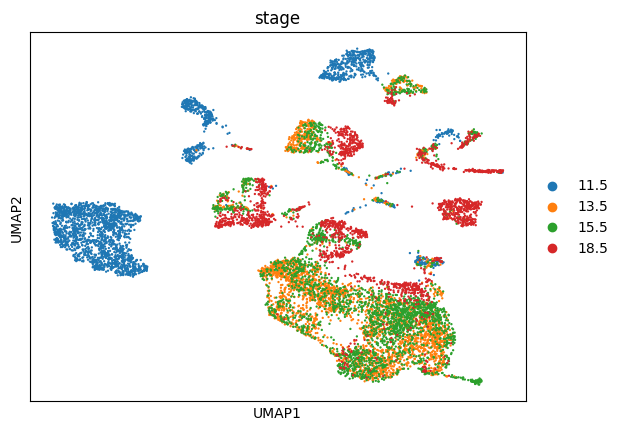

In [12]:
adata = sc.read(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_full.h5ad")
sc.pl.umap(adata,color="stage")